In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [3]:
dataset = r"E:\sem5\ai project\ai_FMDP\dataset1" 
imagePaths = list(paths.list_images(dataset))

In [4]:
data = []    
labels = [] 

for i in imagePaths:
    label = i.split(os.path.sep)[-2]
    labels.append(label)
    image = load_img(i, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image) # reduces the size of input to the model pixel remains same    
    data.append(image)

In [5]:
data = np.array(data,dtype="float32")  # list to numpy array for training
labels = np.array(labels)

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels) # transform the labels 
labels = to_categorical(labels)   # 0 1

In [7]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
train_X, test_X, train_Y, test_Y = train_test_split(data, labels, test_size=0.20, random_state=10, stratify=labels)

In [9]:
aug = ImageDataGenerator(rotation_range =20,
                         zoom_range =0.15,
                         width_shift_range =0.2,
                         height_shift_range =0.2,
                         shear_range =0.15,
                         horizontal_flip =True,
                         vertical_flip =True,
                         fill_mode ="nearest")

In [10]:
# loading MobileNetV2 network excluding last layers
base_Model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [11]:
base_Model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [12]:
# builiding the last layers/top

head_Model = base_Model.output
head_Model = AveragePooling2D(pool_size=(7, 7))(head_Model)
head_Model = Flatten(name="Flatten")(head_Model)
head_Model = Dense(128, activation="relu")(head_Model) # 128 neurons sigmoid relu
head_Model = Dropout(0.5)(head_Model) #0 0.2 0.5 0.9
head_Model = Dense(2, activation="softmax")(head_Model) # 2 - neurons 2 outputs 60% sure wearing mask 40% sure not mask

In [13]:
# connecting the base and top layers
model = Model(inputs = base_Model.input, outputs = head_Model)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [15]:
# train only last layers from averagePooling to dense
# transfer learning
for layer in base_Model.layers:
    layer.trainable = False

In [16]:
INIT_LR = 0.0001  # learning rate 0.001, 0.045, 0.0001
Epochs = 5        # epoches 20, 32
BS = 12           # batch size 

In [17]:
# compiling model loss function, optimizer, metrics

opt = Adam(learning_rate = INIT_LR, decay = INIT_LR / Epochs)
model.compile(loss ="binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [18]:
# training the model 

H = model.fit(aug.flow(train_X, train_Y, batch_size = BS), 
              steps_per_epoch = len(train_X) // BS,
              validation_data = (test_X, test_Y),
              validation_steps = len(test_X) // BS, 
              epochs = Epochs)

Epoch 1/5
91/91 [==============================] - 72s 712ms/step - loss: 0.4753 - accuracy: 0.8097 - val_loss: 0.1798 - val_accuracy: 0.9819
Epoch 2/5
91/91 [==============================] - 62s 678ms/step - loss: 0.2281 - accuracy: 0.9403 - val_loss: 0.0948 - val_accuracy: 0.9855
Epoch 3/5
91/91 [==============================] - 64s 707ms/step - loss: 0.1486 - accuracy: 0.9669 - val_loss: 0.0714 - val_accuracy: 0.9855
Epoch 4/5
91/91 [==============================] - 62s 682ms/step - loss: 0.1244 - accuracy: 0.9678 - val_loss: 0.0629 - val_accuracy: 0.9891
Epoch 5/5
91/91 [==============================] - 63s 694ms/step - loss: 0.0861 - accuracy: 0.9798 - val_loss: 0.0522 - val_accuracy: 0.9891


In [19]:
# model.save(r"C:\Users\lenovo\ai_proj\models\Model3_da\mobilenet_v2.model")
model.save("mobilenet_v2.model", save_format="h5")

E:\anaconda3\envs\ai_course\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [20]:
# evaluating model on test data
predict = model.predict(test_X, batch_size=BS)  
pred = np.argmax(predict, axis=1) # which output has max probability mask or without mask
target = test_Y.argmax(axis=1)
print(classification_report(test_Y.argmax(axis=1), pred , target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       138
without_mask       0.99      0.99      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



In [ ]:
predict

In [ ]:
pred

In [ ]:
test_Y

In [ ]:
target

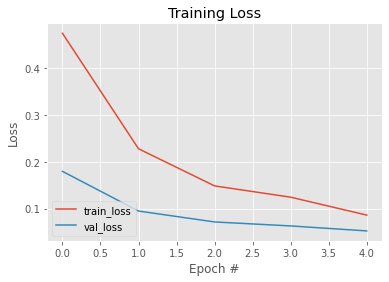

In [25]:
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")

plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot1.png")

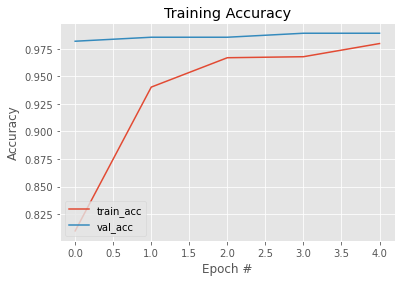

In [26]:
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot2.png")